In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=37a55d58714d31f00f1166029bacb8d5643f0965e009dc0f43ee8cf233277ebe
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=4719e0ef1d76ccd0e97a3f79aab31442025bba2542f6b5f02b9c38dd1af15958
  Stored in directory: /root/.cache/pip/w

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 27.98 MiB/s, done.


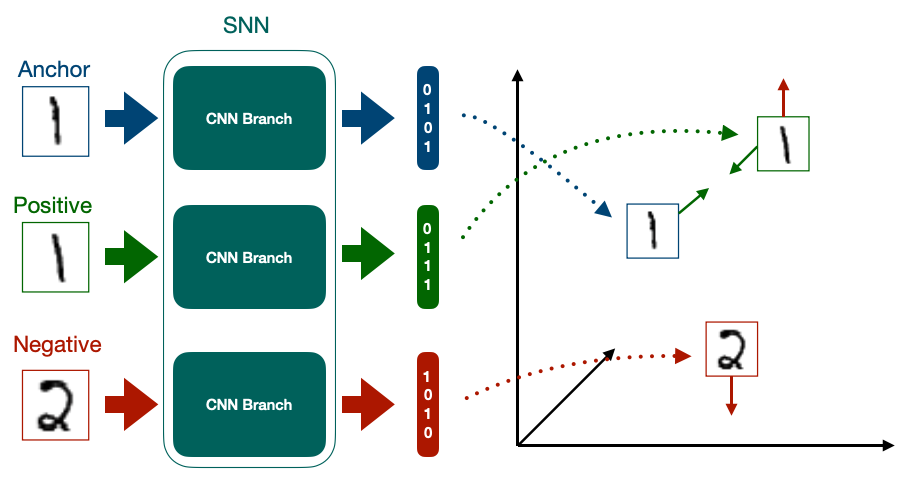

# Imports

In [3]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg
...,...,...,...
3995,0326_c2s3_074602_01.jpg,1336_c6s3_070592_01.jpg,0326_c6s4_007552_02.jpg
3996,0566_c3s2_004562_03.jpg,0952_c5s2_120574_02.jpg,0566_c3s2_004637_02.jpg
3997,0566_c3s2_013637_01.jpg,0197_c3s1_044551_02.jpg,0566_c3s2_004637_02.jpg
3998,0566_c6s2_007768_03.jpg,0674_c3s2_044987_01.jpg,0566_c3s2_004637_02.jpg


In [7]:
row = df.iloc[13]
A_img = io.imread(DATA_DIR + row['Anchor'])
P_img = io.imread(DATA_DIR + row['Positive'])
N_img = io.imread(DATA_DIR + row['Negative'])

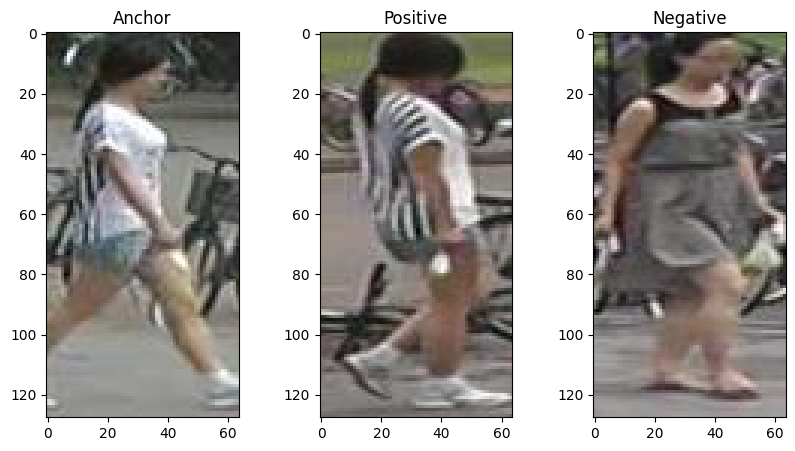

In [8]:
f,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)
ax2.set_title('Positive')
ax2.imshow(P_img)
ax3.set_title('Negative')
ax3.imshow(N_img)

In [9]:
train_df,valid_df = train_test_split(df,test_size=0.2,random_state=42)
print(train_df.shape)
print(valid_df.shape)

(3200, 3)
(800, 3)


# Create APN Dataset 

In [10]:
class APN_Dataset(Dataset):
  def __init__(self,df) -> None:
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self,index):
    row = self.df.iloc[index]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0
    return A_img,P_img,N_img


In [11]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

In [12]:
print(len(trainset))
print(len(validset))

3200
800


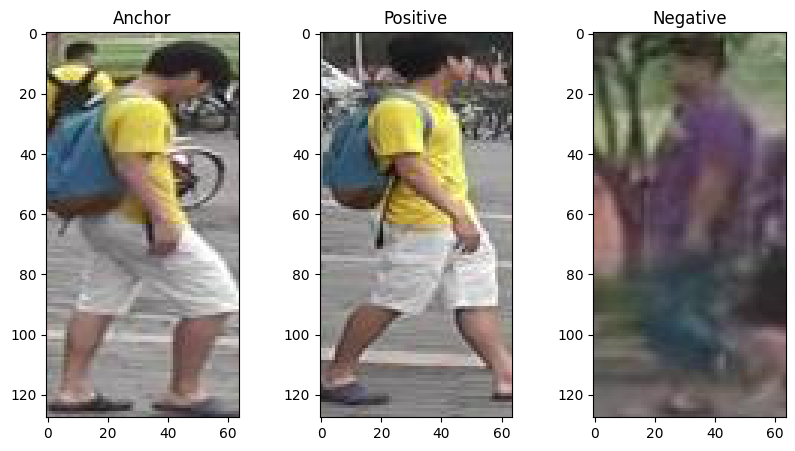

In [13]:
idx = 1
A,P,N = trainset[idx]
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [14]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle=True)

In [15]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [16]:
for A,P,N in trainloader:
  break;
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [17]:
class APN_Model(nn.Module):
  def __init__(self,emb_size=512):
    super(APN_Model,self).__init__()
    # if we have two pararrel APN_Model can be called siamese
    self.efficientnet = timm.create_model('efficientnet_b0',pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self,image):
    embeddings = self.efficientnet(image)
    return embeddings


In [18]:
model = APN_Model()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [19]:
def train_fn(model,dataloader,optimizer,criteration):
  model.train()
  total_loss = 0.0
  for A,P,N in tqdm(dataloader):
    A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)
    loss = criteration(A_embs,P_embs,N_embs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)


In [20]:
def valid_fn(model,dataloader,criteration):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)
      loss = criteration(A_embs,P_embs,N_embs)
      total_loss += loss.item()
    return total_loss / len(dataloader)
    

In [21]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [22]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = valid_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('SAVED_WEIGHTS success')
  
  print(f'EPOCH: {i+1} \t trainloss: {train_loss} \t validloss: {valid_loss}')

100%|██████████| 25/25 [00:02<00:00,  8.98it/s]


SAVED_WEIGHTS success
EPOCH: 1 	 trainloss: 0.6223664532601834 	 validloss: 0.5366665279865265


100%|██████████| 25/25 [00:02<00:00, 10.17it/s]


SAVED_WEIGHTS success
EPOCH: 2 	 trainloss: 0.2856996749341488 	 validloss: 0.3098855233192444


100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


SAVED_WEIGHTS success
EPOCH: 3 	 trainloss: 0.15607392594218253 	 validloss: 0.25502479791641236


100%|██████████| 25/25 [00:02<00:00, 10.09it/s]


SAVED_WEIGHTS success
EPOCH: 4 	 trainloss: 0.07984964415431023 	 validloss: 0.243811651468277


100%|██████████| 25/25 [00:02<00:00,  9.27it/s]


SAVED_WEIGHTS success
EPOCH: 5 	 trainloss: 0.0666231581568718 	 validloss: 0.23758102655410768


100%|██████████| 25/25 [00:02<00:00,  9.19it/s]


EPOCH: 6 	 trainloss: 0.06971430838108063 	 validloss: 0.24495283424854278


100%|██████████| 25/25 [00:02<00:00,  9.79it/s]


SAVED_WEIGHTS success
EPOCH: 7 	 trainloss: 0.07608212359249591 	 validloss: 0.21296594202518462


100%|██████████| 25/25 [00:02<00:00,  9.46it/s]


SAVED_WEIGHTS success
EPOCH: 8 	 trainloss: 0.06044059194624424 	 validloss: 0.14124195635318756


100%|██████████| 25/25 [00:02<00:00,  8.51it/s]


EPOCH: 9 	 trainloss: 0.03637304723262787 	 validloss: 0.20917974293231964


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


EPOCH: 10 	 trainloss: 0.04555648408830166 	 validloss: 0.17821887850761414


100%|██████████| 25/25 [00:02<00:00,  8.55it/s]


EPOCH: 11 	 trainloss: 0.033646658062934875 	 validloss: 0.17596770346164703


100%|██████████| 25/25 [00:03<00:00,  7.99it/s]


EPOCH: 12 	 trainloss: 0.04746877036988735 	 validloss: 0.17855770587921144


100%|██████████| 25/25 [00:02<00:00,  8.79it/s]


EPOCH: 13 	 trainloss: 0.037377056181430814 	 validloss: 0.14393487930297852


100%|██████████| 25/25 [00:02<00:00,  9.20it/s]


EPOCH: 14 	 trainloss: 0.02793231874704361 	 validloss: 0.16410804092884063


100%|██████████| 25/25 [00:02<00:00,  9.46it/s]

EPOCH: 15 	 trainloss: 0.04009978957474232 	 validloss: 0.1979860857129097


# Get Anchor Embeddings

In [28]:
def get_encoding_csv(model,anc_image_names):
  anc_img_names_arr = np.array(anc_image_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_image_names, encodings], axis=1)
    return df_enc

In [29]:
model.load_state_dict(torch.load('/content/best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:45<00:00, 88.51it/s]


In [30]:
df_enc.to_csv('/content/database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.620169,0.626042,0.727073,0.732898,0.095372,-0.077193,-0.717246,-0.124289,-0.100768,...,-0.077906,-0.057153,-0.111475,0.467781,-0.318406,-0.600394,0.238495,0.128244,-0.230786,0.223328
1,1420_c3s3_061978_03.jpg,-0.673864,0.655699,0.805991,0.777779,0.168744,-0.028122,-0.907584,-0.186495,-0.108639,...,0.068641,-0.373478,0.091483,0.416791,-0.448139,-0.405335,-0.117852,0.077825,-0.357405,0.242974
2,1420_c5s3_062565_05.jpg,-0.547422,0.530601,0.712139,0.658025,0.433512,-0.042222,-0.673820,-0.124208,0.048070,...,0.165364,-0.242928,-0.124834,0.536097,-0.392434,-0.513895,0.120315,0.058667,-0.075034,0.268697
3,1420_c6s3_085592_04.jpg,-0.511950,0.664092,0.788728,0.742229,0.380525,-0.060483,-0.493493,-0.149814,0.017156,...,-0.046163,-0.020790,-0.118756,0.340273,-0.200359,-0.371480,0.260452,0.146031,-0.363637,0.268929
4,0663_c5s3_085987_03.jpg,0.076971,0.293536,0.528446,-0.344544,-0.855563,0.145734,0.253520,-0.307633,-0.295449,...,-0.247035,0.598609,0.422144,-0.882612,0.754135,0.747952,0.120341,0.085257,-0.043918,-1.217962


# Inference

In [31]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [32]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [33]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [34]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1 :])
  distance = np.append(distance, dist)

In [35]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.9/dist-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


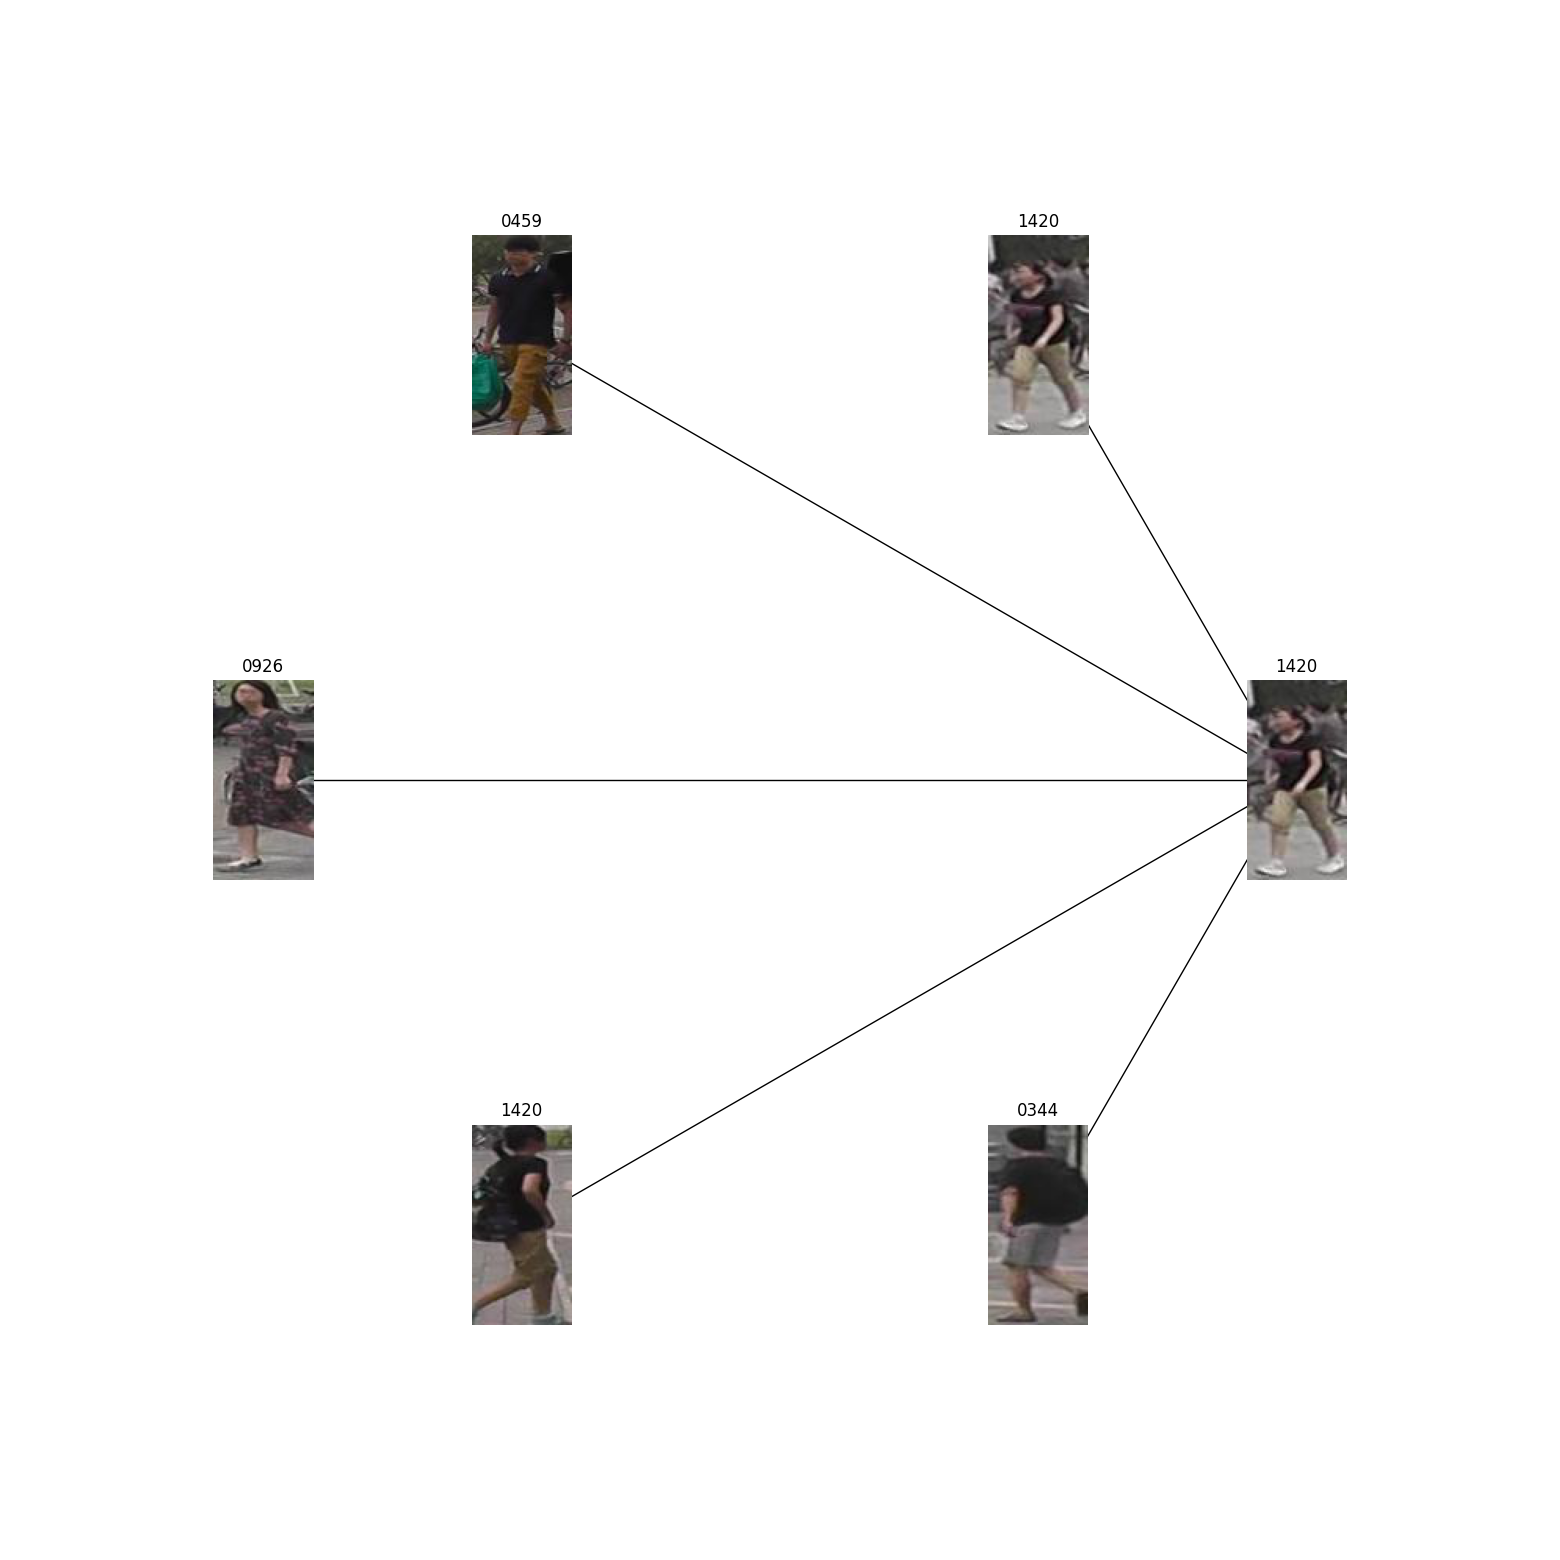

In [36]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);